<a href="https://colab.research.google.com/github/VadPA/Introduction_to_AI/blob/master/image_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from google.colab import files
from io import BytesIO
from PIL import Image
from keras.preprocessing import image as kp_image

In [16]:
upl = files.upload()
img_style = Image.open(BytesIO(upl['img_style_0.jpg']))

Saving img_style_0.jpg to img_style_0.jpg


In [13]:
upl = files.upload()
img = Image.open(BytesIO(upl['img_2_2.jpg']))

Saving img_2_2.jpg to img_2_2 (6).jpg


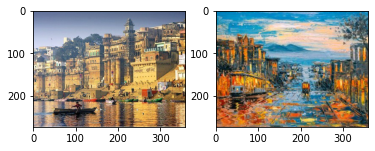

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_style)
plt.show()

In [18]:
x_img = keras.applications.vgg19.preprocess_input(np.expand_dims(img, axis=0))
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))

In [19]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
    assert len(x.shape) == 3 , ('Input to deprocess image must be an image of')

  if len(x.shape) != 3:
    raise ValueError('Invalid input to deprocessing image')

  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [20]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [21]:
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [22]:
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

print(vgg.input)
for m in model_outputs:
  print(m)

model = keras.models.Model(vgg.input, model_outputs)
print(model.summary())

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
K

In [23]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [25]:
def get_feature_representations(model):
  style_outputs = model(x_style)
  content_outputs = model(x_img)

  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

  return style_features, content_features

In [24]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  heigth, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)

  return tf.reduce_mean(tf.square(gram_style - gram_target))

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights

  model_outputs = model(init_image)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score = 0
  content_score = 0

  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)

  style_score *= style_weight
  content_score *= content_weight

  loss = style_score + content_score

  return loss, style_score, content_score



In [28]:
num_iterations = 100
content_weight = 1e3
style_weight = 1e-2

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

opt = tf.compat.v1.train.AdadeltaOptimizer(learning_rate=2, rho=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = {
    'model': model,
    'loss_weights': loss_weights,
    'init_image': init_image,
    'gram_style_features': gram_style_features,
    'content_features': content_features,
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

for i in range(num_iterations):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)

  total_loss = all_loss[0]
  grads = tape.gradient(total_loss, init_image)

  loss, style_score, content_score = all_loss
  opt.apply_gradients([(grads, init_image)])
  clipped = tf.clip_by_value(init_image, min_vals, max_vals)
  init_image.assign(clipped)

  if loss < best_loss:
    best_loss = loss
    best_img = deprocess_img(init_image.numpy())

    plot_img = deprocess_img(init_image.numpy())
    imgs.append(plot_img)
    print('Iteration: {}'.format(i))



Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 4
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 53
Iteration: 54
Iteration: 56
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 71
Iteration: 72
Iteration: 73
Iteration: 74
Iteration: 75
Iteration: 76


tf.Tensor(4680827.5, shape=(), dtype=float32)


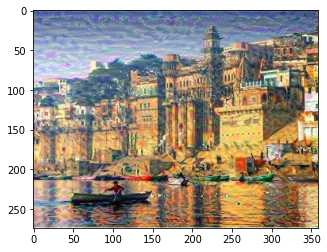

In [29]:
plt.imshow(best_img)
print(best_loss)

In [30]:
image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save('out.jpg')
files.download('out.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>